Data was downloaded from the following link: __[Room Occupancy Estimation](https://archive.ics.uci.edu/dataset/864/room+occupancy+estimation)__

The notebook uses the following structure:

For each ML technique:
- Perform a GridSearchCV over a specified grid of parameters
- Fit the models and obtain relevant accuracy metrics
- (Optionally) further investigation

Generate all of the general tables/graphs at the end

In [ ]:
#General imports
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time

#Imports for preprocessing, model selection, and metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, auc, f1_score, ConfusionMatrixDisplay

#Imports of models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.decomposition import PCA #For visualisation

#Misc. imports
from sklearn.tree import export_graphviz
from IPython.display import Image

In [ ]:
#Read .csv
df = pd.read_csv("Occupancy_Estimation.csv")

In [ ]:
#Get X, y as numpy arrays
X = df.drop(['Room_Occupancy_Count', 'Date', 'Time'], axis=1).values
y = df['Room_Occupancy_Count'].values

#Feature labels
feature_labels = df.drop(['Room_Occupancy_Count', 'Date', 'Time'], axis=1).columns

#Check the number of observations and that X, y fit
print(X.shape, y.shape)

#80/20 split into training/validation sets (with stratification)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420, stratify=y)

#Check the shapes again
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#Scale the features using scaler based on the training data (so that there is no data leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

(10129, 16) (10129,)
(8103, 16) (2026, 16) (8103,) (2026,)


In [ ]:
#Dictionary used for storing model metrics. Follows the form of details_of['model_name']['metric']
details_of = {}

# Logistic Regression

In [ ]:
#Logistic regression
logistic_regression = LogisticRegression(max_iter=10000)

logistic_regression_param_grid = {
    'C':np.logspace(-3, 5, 9), #Values from 0.001 to 100,000
    'class_weight':[None, 'balanced'],
    'multi_class':['ovr', 'multinomial']
    }

#Note: takes about 6 minutes to run
logistic_regression_search = GridSearchCV(
    estimator=logistic_regression,
    param_grid=logistic_regression_param_grid,
    scoring='accuracy', #Overall accuracy as the scoring metric
    cv=5, #5-fold cross-validation
    verbose=2)

logistic_regression_search.fit(X_train_scaled, y_train)
logistic_regression = logistic_regression_search.best_estimator_

start = time.time()
logistic_regression.fit(X_train_scaled, y_train)
logistic_regression_time_taken = time.time() - start

logistic_regression_y_pred = logistic_regression.predict(X_test_scaled)
logistic_regression_y_pred_proba = logistic_regression.predict_proba(X_test_scaled)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ........C=0.001, class_weight=None, multi_class=ovr; total time=   0.2s
[CV] END ........C=0.001, class_weight=None, multi_class=ovr; total time=   0.1s
[CV] END ........C=0.001, class_weight=None, multi_class=ovr; total time=   0.1s
[CV] END ........C=0.001, class_weight=None, multi_class=ovr; total time=   0.1s
[CV] END ........C=0.001, class_weight=None, multi_class=ovr; total time=   0.1s
[CV] END C=0.001, class_weight=None, multi_class=multinomial; total time=   0.1s
[CV] END C=0.001, class_weight=None, multi_class=multinomial; total time=   0.1s
[CV] END C=0.001, class_weight=None, multi_class=multinomial; total time=   0.2s
[CV] END C=0.001, class_weight=None, multi_class=multinomial; total time=   0.2s
[CV] END C=0.001, class_weight=None, multi_class=multinomial; total time=   0.2s
[CV] END ....C=0.001, class_weight=balanced, multi_class=ovr; total time=   0.1s
[CV] END ....C=0.001, class_weight=balanced, mu

In [ ]:
details_of['logistic_regression'] = {
    'accuracy_score':accuracy_score(y_test, logistic_regression_y_pred),
    'best_parameters':logistic_regression_search.best_params_,
    'f1_score':f1_score(y_test, logistic_regression_y_pred, average='macro'),
    'roc_auc_score':roc_auc_score(y_test, logistic_regression_y_pred_proba, average='weighted', multi_class='ovr'),
    'time_taken':logistic_regression_time_taken
}

In [ ]:
#Obtain the coefficients
logistic_regression_coefficients = pd.DataFrame({
    'class_0':logistic_regression.coef_[0,:],
    'class_1':logistic_regression.coef_[1,:],
    'class_2':logistic_regression.coef_[2,:],
    'class_3':logistic_regression.coef_[3,:]
}, index=df.drop(['Room_Occupancy_Count', 'Date', 'Time'], axis=1).columns)

logistic_regression_coefficients.head(16)

,class_0,class_1,class_2,class_3
S1_Temp,2.404469,1.423964,-2.864319,-0.964115
S2_Temp,-0.496138,-2.656050,1.147487,2.004701
S3_Temp,-9.675260,-5.738294,10.015760,5.397794
S4_Temp,7.260268,3.511188,-7.839364,-2.932091
S1_Light,-8.258481,11.603193,8.809457,-12.154169
S2_Light,-2.152303,-9.420998,1.230965,10.342337
S3_Light,-3.944505,-4.588161,2.671440,5.861225
S4_Light,0.276272,7.406443,-2.949931,-4.732785
S1_Sound,-0.226449,0.316625,0.072803,-0.162979
S2_Sound,0.868696,-2.165405,0.628509,0.668199


# LDA and QDA

In [ ]:
#LDA & QDA
lda = LDA()

start = time.time()
lda.fit(X_train_scaled, y_train)
lda_time_taken = time.time() - start

lda_y_pred, lda_y_pred_proba = lda.predict(X_test_scaled), lda.predict_proba(X_test_scaled)

details_of['LDA'] = {
    'accuracy_score':accuracy_score(y_test, lda_y_pred),
    'best_parameters':None,
    'f1_score':f1_score(y_test, lda_y_pred, average='macro'),
    'roc_auc_score':roc_auc_score(y_test, lda_y_pred_proba, average='weighted', multi_class='ovr'),
    'time_taken':lda_time_taken
}

qda = QDA()
start = time.time()
qda.fit(X_train_scaled, y_train)
qda_time_taken = time.time() - start
qda_y_pred, qda_y_pred_proba = qda.predict(X_test_scaled), qda.predict_proba(X_test_scaled)

details_of['QDA'] = {
    'accuracy_score':accuracy_score(y_test, qda_y_pred),
    'best_parameters':None,
    'f1_score':f1_score(y_test, qda_y_pred, average='macro'),
    'roc_auc_score':roc_auc_score(y_test, qda_y_pred_proba, average='weighted', multi_class='ovr'),
    'time_taken':qda_time_taken
}

# KNN

In [ ]:
# Create a k-NN classifier
knn = KNN()

# Define the hyperparameter grid to search
knn_param_grid = {
    'n_neighbors': [1, 3, 5, 6, 7, 8],   # Different values of k
    'weights': ['uniform', 'distance'],
    'p': [1, 2],                # L1 or L2 distance
    'metric': ['euclidean', 'manhattan']
}

#Note: takes about 5 seconds to run
knn_search = GridSearchCV(knn, knn_param_grid, cv=5, scoring='accuracy')
knn_search.fit(X_train_scaled, y_train)
knn = knn_search.best_estimator_

start = time.time()
knn.fit(X_train_scaled, y_train)
knn_time_taken = time.time() - start

knn_y_pred = knn.predict(X_test_scaled)
knn_y_pred_proba = knn.predict_proba(X_test_scaled)

In [ ]:
details_of['KNN'] = {
    'accuracy_score':accuracy_score(y_test,knn_y_pred),
    'best_parameters':knn_search.best_params_,
    'f1_score':f1_score(y_test, knn_y_pred, average='macro'),
    'roc_auc_score':roc_auc_score(y_test, knn_y_pred_proba, average='weighted', multi_class='ovr'),
    'time_taken':knn_time_taken
}

Minimum error:- 0.006910167818361303 at K = 6


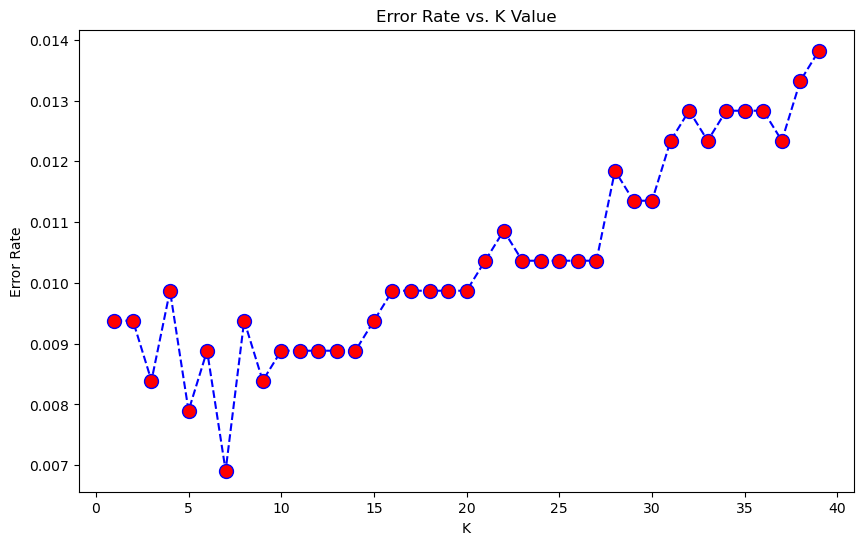

In [ ]:
#Get error rate vs k plot
error_rate = []
for i in range(1,40):
    knn = KNN(n_neighbors=i)
    knn.fit(X_train_scaled,y_train)
    pred_i = knn.predict(X_test_scaled)
    error_rate.append(np.mean(pred_i != y_test))
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed',
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

Maximum accuracy: 0.9930898321816387 at K = 7


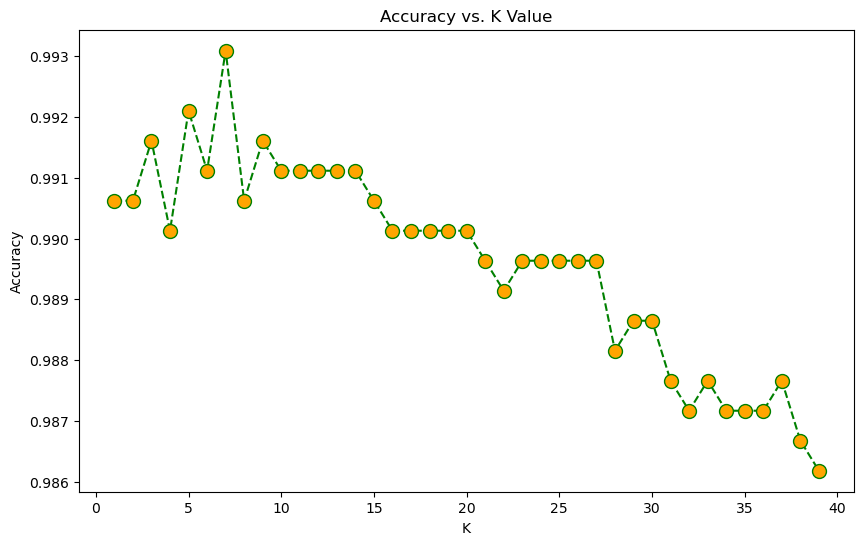

In [ ]:
#Get accuracy vs k plot
accuracy_values = []

for i in range(1, 40):
    knn = KNN(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    pred_i = knn.predict(X_test_scaled)
    accuracy_values.append(accuracy_score(y_test, pred_i))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 40), accuracy_values, color='green', linestyle='dashed',
         marker='o', markerfacecolor='orange', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:", max(accuracy_values), "at K =", accuracy_values.index(max(accuracy_values)) + 1)

# Decision tree

In [ ]:
# Grid Search
dt_classifier = DecisionTreeClassifier(random_state = 420)

dt_classifier_param_grid = {
    'criterion': ['gini', 'entropy'],         # Criterion used to measure the quality of a split
    'splitter': ['best', 'random'],           # Strategy used to choose the split at each node
    'max_depth': [None, 5, 10, 15],            # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],           # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],             # Minimum number of samples required to be at a leaf node
}

#Note: takes about 4 seconds to run
dt_classifier_search = GridSearchCV(estimator=dt_classifier, param_grid=dt_classifier_param_grid, scoring='accuracy', cv=5)
dt_classifier_search.fit(X_train, y_train)
dt_classifier = dt_classifier_search.best_estimator_

start = time.time()
dt_classifier.fit(X_train,y_train)
dt_classifier_time_taken = time.time() - start

dt_classifier_y_pred = dt_classifier.predict(X_test)
dt_classifier_y_pred_proba = dt_classifier.predict_proba(X_test)

details_of['decision_tree'] = {
    'accuracy_score':accuracy_score(y_test,dt_classifier_y_pred),
    'best_parameters':dt_classifier_search.best_params_,
    'f1_score':f1_score(y_test, dt_classifier_y_pred, average='macro'),
    'roc_auc_score':roc_auc_score(y_test, dt_classifier_y_pred_proba, average='weighted', multi_class='ovr'),
    'time_taken':dt_classifier_time_taken
}

# XGBoost

In [ ]:
xgboost = XGBClassifier(objective = 'multi:softprob', random_state = 420)

xgboost_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage to prevent overfitting
    'n_estimators': [100, 200, 500],  # Number of boosting rounds
    'max_depth': [3, 6, 10],  # Maximum depth of a tree
    'subsample': [0.8, 0.9, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.5, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
}

#Note: takes about 3.5 minutes to run
xgboost_search = GridSearchCV(xgboost, param_grid = xgboost_param_grid, scoring = 'accuracy',
                          cv = 3, n_jobs = -1, verbose = 2)
xgboost_search.fit(X_train,y_train)
xgboost = xgboost_search.best_estimator_

start = time.time()
xgboost.fit(X_train, y_train)
xgboost_time_taken = time.time() - start

xgboost_y_pred = xgboost.predict(X_test)
xgboost_y_pred_proba = xgboost.predict_proba(X_test)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END 

In [ ]:
details_of['xgboost'] = {
    'accuracy_score':accuracy_score(y_test, xgboost_y_pred),
    'best_parameters':xgboost_search.best_params_,
    'f1_score':f1_score(y_test, xgboost_y_pred, average='macro'),
    'roc_auc_score':roc_auc_score(y_test, xgboost_y_pred_proba, average='weighted', multi_class='ovr'),
    'time_taken':xgboost_time_taken
}

<Axes: xlabel='Feature Importance', ylabel='Features'>

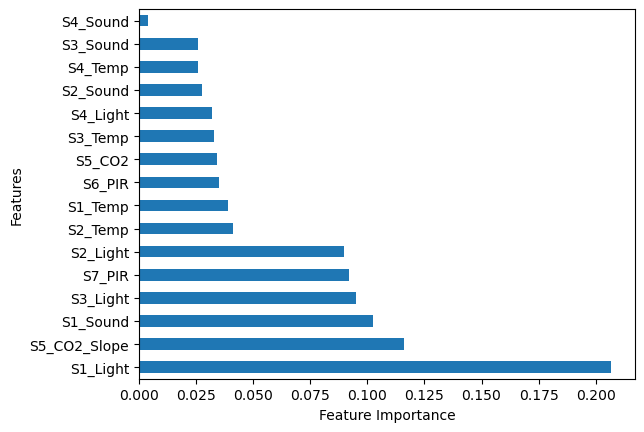

In [ ]:
#Feature Importance
FI = xgboost.feature_importances_
FI = pd.Series(FI, index=feature_labels).sort_values(ascending = False)
FI.plot(kind='barh', xlabel= 'Feature Importance', ylabel = 'Features')

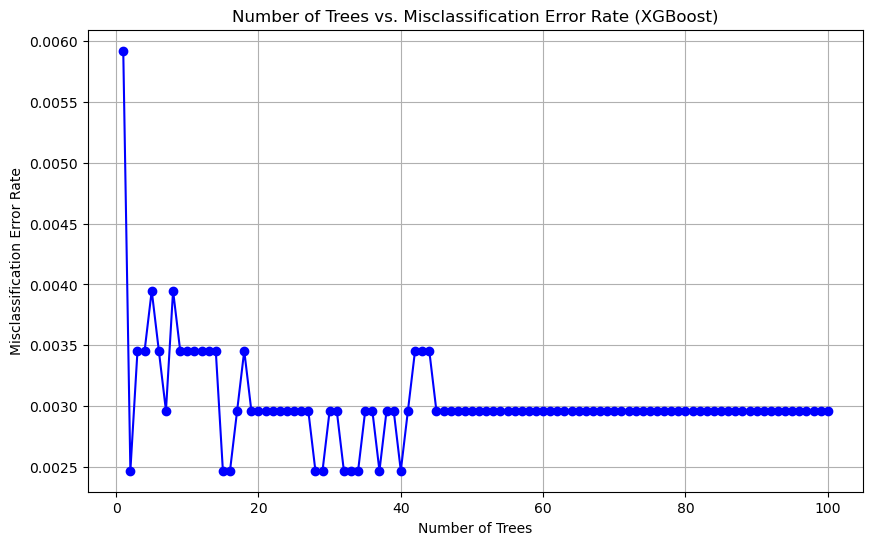

In [ ]:
#Plot number of trees vs error rate
max_trees = 100
num_trees = np.arange(1, max_trees + 1)
error_rates = []

for n in num_trees:
    xgb_model = XGBClassifier(n_estimators=n, random_state=420)

    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)

    error_rate = 1 - accuracy_score(y_test, y_pred)
    error_rates.append(error_rate)

# Plot the number of trees versus misclassification error rate
plt.figure(figsize=(10, 6))
plt.plot(num_trees, error_rates, marker='o', linestyle='-', color='b')
plt.title('Number of Trees vs. Misclassification Error Rate (XGBoost)')
plt.xlabel('Number of Trees')
plt.ylabel('Misclassification Error Rate')
plt.grid(True)
plt.show()

# Random Forest

In [ ]:
rf = RandomForestClassifier(random_state = 420)

rf_param_grid = {
    'n_estimators': [50, 100, 200, 500],                  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],                # Criterion used to measure the quality of a split
    'max_depth': [None, 10, 20, 30],                  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],                  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],                    # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider for the best split
}

#Note: takes about 5.5 minutes to run
rf_search = GridSearchCV(estimator = rf, param_grid = rf_param_grid,
                          cv = 3, n_jobs = -1, verbose = 2, scoring = 'accuracy')
rf_search.fit(X_train,y_train)
rf = rf_search.best_estimator_

start = time.time()
rf.fit(X_train, y_train)
rf_time_taken = time.time() - start

rf_y_pred = rf.predict(X_test)
rf_y_pred_proba = rf.predict_proba(X_test)

Fitting 3 folds for each of 864 candidates, totalling 2592 fits
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimato

In [ ]:
details_of['random_forest'] = {
    'accuracy_score':accuracy_score(y_test, rf_y_pred),
    'best_parameters':rf_search.best_params_,
    'f1_score':f1_score(y_test, rf_y_pred, average='macro'),
    'roc_auc_score':roc_auc_score(y_test, rf_y_pred_proba, average='weighted', multi_class='ovr'),
    'time_taken':rf_time_taken
}

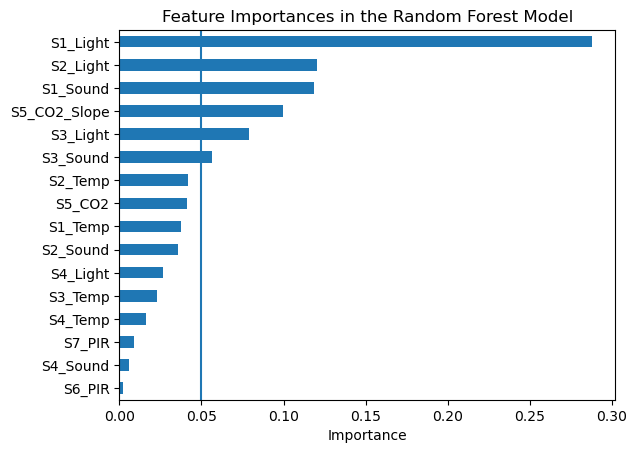

In [ ]:
rf_feature_importances = pd.Series(rf.feature_importances_, index=feature_labels).sort_values(ascending=True)
rf_feature_importances.plot(kind='barh')
plt.title("Feature Importances in the Random Forest Model")
plt.xlabel("Importance")
plt.axvline(0.05)
plt.show()

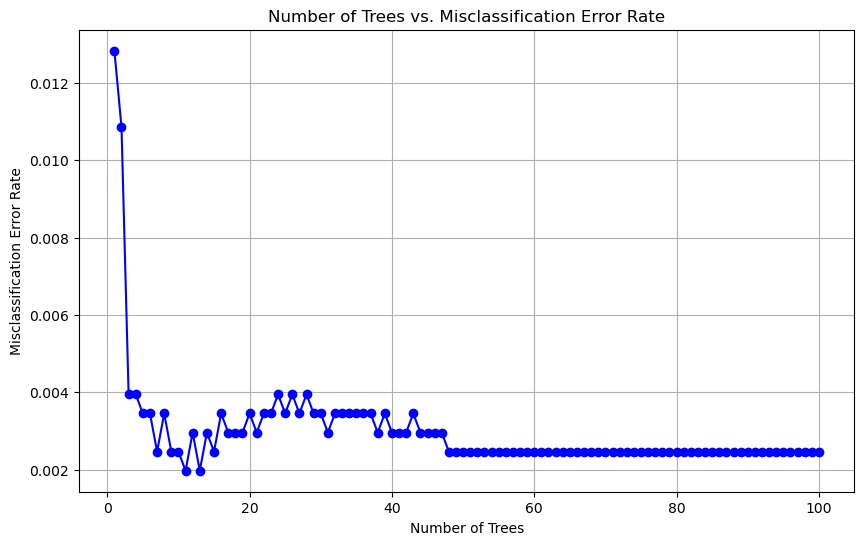

In [ ]:
#Plot number of trees vs misclassification error rate
max_trees = 100
num_trees = np.arange(1, max_trees + 1)
error_rates = []

for n in num_trees:
    rf_model = RandomForestClassifier(n_estimators=n, random_state=420)
    rf_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = rf_model.predict(X_test)

    # Calculate misclassification error rate
    error_rate = 1 - accuracy_score(y_test, y_pred)
    error_rates.append(error_rate)

# Plot the number of trees versus misclassification error rate
plt.figure(figsize=(10, 6))
plt.plot(num_trees, error_rates, marker='o', linestyle='-', color='b')
plt.title('Number of Trees vs. Misclassification Error Rate')
plt.xlabel('Number of Trees')
plt.ylabel('Misclassification Error Rate')
plt.grid(True)
plt.show()

# Naive Bayes

In [ ]:
nvbayes = GaussianNB()

start = time.time()
nvbayes.fit(X_train, y_train)
nvbayes_time_taken = time.time() - start

nvbayes_y_pred = nvbayes.predict(X_test)
nvbayes_y_pred_proba = nvbayes.predict_proba(X_test)

In [ ]:
details_of['naive_bayes'] = {
    'accuracy_score':accuracy_score(y_test, nvbayes_y_pred),
    'best_parameters':None,
    'f1_score':f1_score(y_test, nvbayes_y_pred, average='macro'),
    'roc_auc_score':roc_auc_score(y_test, nvbayes_y_pred_proba, average='weighted', multi_class='ovr'),
    'time_taken':nvbayes_time_taken
}

# SVM

In [ ]:
# SVM Grid Search Cross Validation
svc = SVC(probability = True)

svc_param_grid = {'C': [0.1, 1, 10, 100],  # C = 1000 is very high and a very high C can cause overfitting
              'gamma': [1, 0.1, 0.01, 0.001, 'scale'],  # gamma = 0.0001 is very low and very far away points are also considered to get decision boundary and this is not required
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

#Note: takes about 4 minutes to run
svc_search = GridSearchCV(svc, svc_param_grid, refit = True, verbose = 2, scoring = 'accuracy')
svc_search.fit(X_train_scaled, y_train)
svc = svc_search.best_estimator_

start = time.time()
svc.fit(X_train_scaled, y_train)
svc_time_taken = time.time() - start

svc_y_pred = svc.predict(X_test_scaled)
svc_y_pred_proba = svc.predict_proba(X_test_scaled)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.8s
[CV] END .........................C=0.1, gamma=

## Outputs for the report

/var/folders/dv/62fsr9b113z_pwgzxcrl64140000gn/T/ipykernel_90171/2284463914.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.describe().to_latex()) #Brief summary statistics of features for the appendix


\begin{tabular}{lrrrrrrrrrrrrrrrrr}
\toprule
{} &       S1\_Temp &       S2\_Temp &       S3\_Temp &       S4\_Temp &      S1\_Light &     S2\_Light &      S3\_Light &      S4\_Light &      S1\_Sound &      S2\_Sound &      S3\_Sound &      S4\_Sound &        S5\_CO2 &  S5\_CO2\_Slope &        S6\_PIR &        S7\_PIR &  Room\_Occupancy\_Count \\
\midrule
count &  10129.000000 &  10129.000000 &  10129.000000 &  10129.000000 &  10129.000000 &  10129.00000 &  10129.000000 &  10129.000000 &  10129.000000 &  10129.000000 &  10129.000000 &  10129.000000 &  10129.000000 &  10129.000000 &  10129.000000 &  10129.000000 &          10129.000000 \\
mean  &     25.454012 &     25.546059 &     25.056621 &     25.754125 &     25.445059 &     26.01629 &     34.248494 &     13.220259 &      0.168178 &      0.120066 &      0.158119 &      0.103840 &    460.860401 &     -0.004830 &      0.090137 &      0.079574 &              0.398559 \\
std   &      0.351351 &      0.586325 &      0.427283 &      0.356

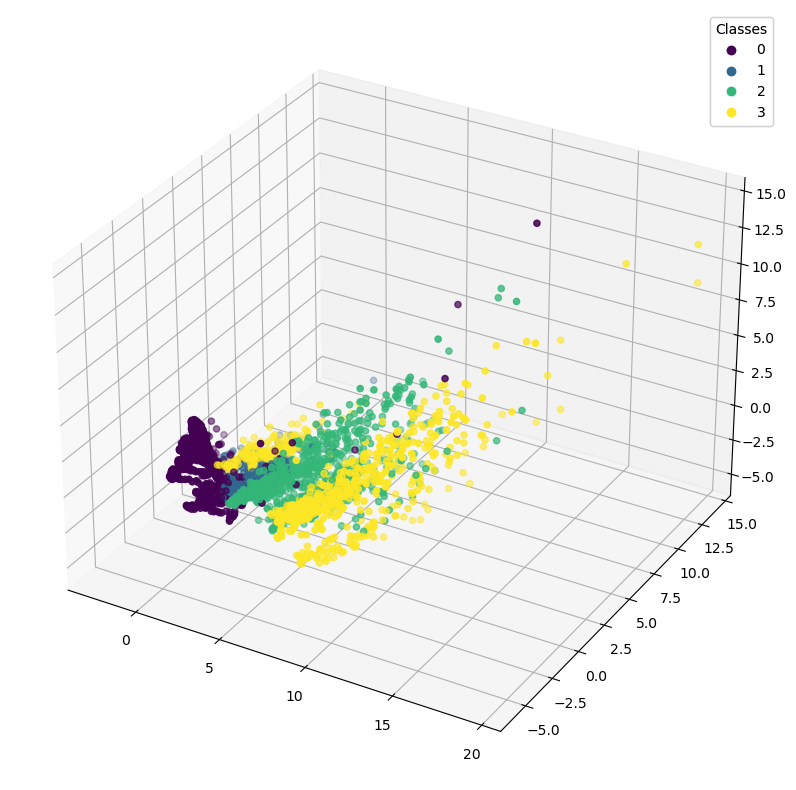

In [ ]:
#Use this cell for EDA, generating summary statistics, etc.
df.groupby("Room_Occupancy_Count").size() / 10129 * 100 #Used to get the number of observations per occupancy in section 2.

print(df.describe().to_latex()) #Brief summary statistics of features for the appendix

#PCA for visualisation
pca = PCA(n_components=3)

full_scaler_for_pca = StandardScaler()
X_scaled = full_scaler_for_pca.fit_transform(X)

X_scaled_reduced = pca.fit_transform(X_scaled)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

scatter3d = ax.scatter3D(X_scaled_reduced[:, 0], X_scaled_reduced[:, 1], X_scaled_reduced[:, 2], c=y)

legend1 = ax.legend(*scatter3d.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend1)

print("PCA n=3 explained variance: ", pca.explained_variance_ratio_.sum())

In [ ]:
details_of['SVM'] = {
    'accuracy_score':accuracy_score(y_test, svc_y_pred),
    'best_parameters':svc_search.best_params_,
    'f1_score':f1_score(y_test, svc_y_pred, average='macro'),
    'roc_auc_score':roc_auc_score(y_test, svc_y_pred_proba, average='weighted', multi_class='ovr'),
    'time_taken':svc_time_taken
}

In [ ]:
details = pd.DataFrame(details_of).T
details = details.sort_values('accuracy_score', ascending=False)
details['accuracy_score'] = details['accuracy_score'].astype('float').round(8) * 100
details['f1_score'] = details['f1_score'].astype('float').round(8) * 100
details['roc_auc_score'] = details['roc_auc_score'].astype('float').round(8) * 100
details.head(10)

,accuracy_score,best_parameters,f1_score,roc_auc_score,time_taken
random_forest,99.753208,"{'criterion': 'entropy', 'max_depth': None, 'm...",99.162347,99.971101,0.295683
xgboost,99.703850,"{'colsample_bytree': 0.5, 'learning_rate': 0.1...",98.988705,99.997527,0.5482
KNN,99.555775,"{'metric': 'manhattan', 'n_neighbors': 5, 'p':...",98.508257,99.972037,0.000564
decision_tree,99.555775,"{'criterion': 'entropy', 'max_depth': None, 'm...",98.615975,99.550798,0.009333
SVM,99.457058,"{'C': 10, 'gamma': 1, 'kernel': 'linear'}",98.201402,99.982803,0.405232
logistic_regression,99.358342,"{'C': 100.0, 'class_weight': None, 'multi_clas...",97.853643,99.992808,4.084508
QDA,99.259625,NaN,97.619937,99.932292,0.016071
LDA,98.568608,NaN,95.697241,99.968224,0.059556
naive_bayes,96.692991,NaN,90.534886,99.726042,0.00253


In [ ]:
print(details.loc[:, details.columns != 'best_parameters'].to_latex())

\begin{tabular}{lrrrl}
\toprule
{} &  accuracy\_score &   f1\_score &  roc\_auc\_score & time\_taken \\
\midrule
random\_forest       &       99.753208 &  99.162347 &      99.971101 &   0.295683 \\
xgboost             &       99.703850 &  98.988705 &      99.997527 &     0.5482 \\
KNN                 &       99.555775 &  98.508257 &      99.972037 &   0.000564 \\
decision\_tree       &       99.555775 &  98.615975 &      99.550798 &   0.009333 \\
SVM                 &       99.457058 &  98.201402 &      99.982803 &   0.405232 \\
logistic\_regression &       99.358342 &  97.853643 &      99.992808 &   4.084508 \\
QDA                 &       99.259625 &  97.619937 &      99.932292 &   0.016071 \\
LDA                 &       98.568608 &  95.697241 &      99.968224 &   0.059556 \\
naive\_bayes         &       96.692991 &  90.534886 &      99.726042 &    0.00253 \\
\bottomrule
\end{tabular}



/var/folders/dv/62fsr9b113z_pwgzxcrl64140000gn/T/ipykernel_90171/1510531132.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(details.loc[:, details.columns != 'best_parameters'].to_latex())


In [ ]:
print(details.loc[:, details.columns == 'best_parameters'].to_csv()) #To latex cuts off the parameters

,best_parameters
random_forest,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}"
xgboost,"{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 1.0}"
KNN,"{'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}"
decision_tree,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}"
SVM,"{'C': 10, 'gamma': 1, 'kernel': 'linear'}"
logistic_regression,"{'C': 100.0, 'class_weight': None, 'multi_class': 'multinomial'}"
QDA,
LDA,
naive_bayes,



In [ ]:
#Custom function for plotting ROCs
labels = ['class 0', 'class 1', 'class 2', 'class 3']

def print_roc_for(ax, model, name_of_classifier, scaled_X=True):
    y_prob = model.predict_proba(X_test_scaled if scaled_X else X_test)

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    n_classes = len(set(y))

    for i in range(n_classes):
        # Convert the labels to binary (one-vs-rest)
        binary_labels = (y_test == i).astype(int)

        # Compute ROC curve and AUC
        fpr[i], tpr[i], _ = roc_curve(binary_labels, y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot ROC curve for each class
        ax.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    # Plot the diagonal line (random classifier)
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    # ax.xlabel('False Positive Rate')
    # ax.ylabel('True Positive Rate')
    ax.set_title('ROC Curve for ' + name_of_classifier)
    ax.legend(loc='lower right')

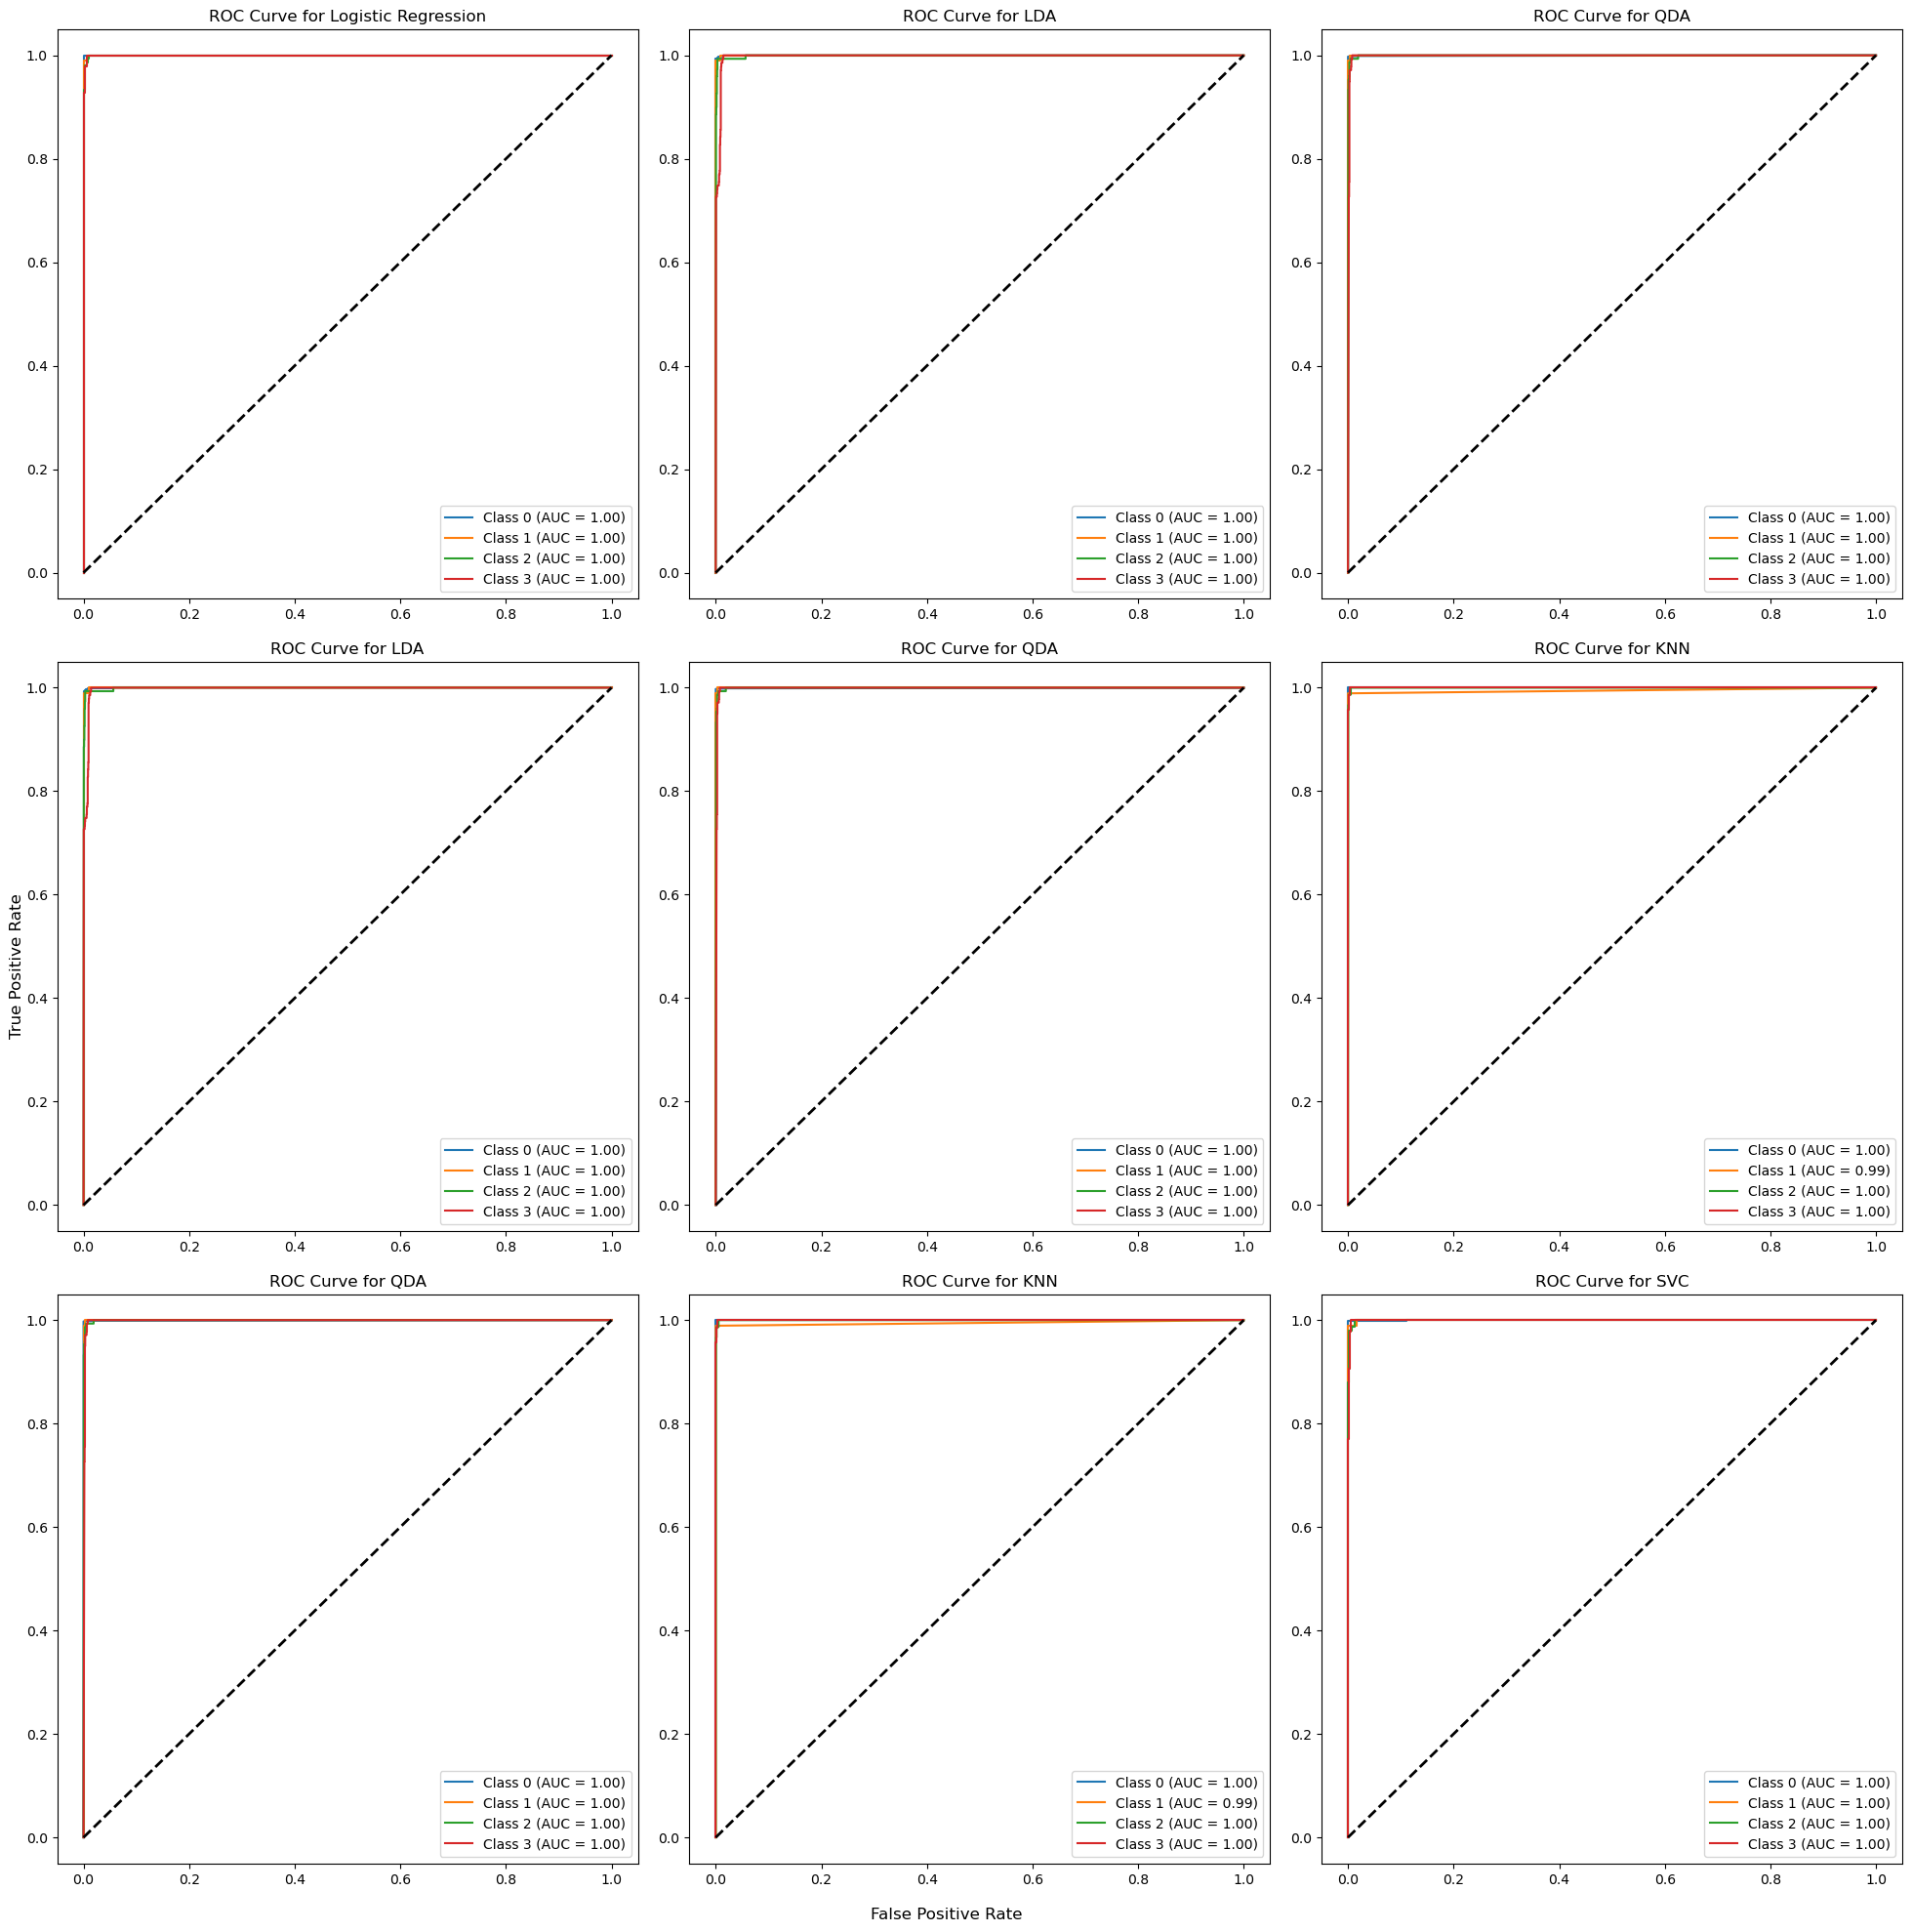

In [ ]:
fig, axs = plt.subplots(nrows=3,ncols=3, figsize=(20,20))

models = [
    (logistic_regression, "Logistic Regression", True),
    (lda, "LDA", True),
    (qda, "QDA", True),
    (knn, "KNN", True),
    (svc, "SVC", True),
    (nvbayes, "NB", False),
    (xgboost, "XGB", False),
    (rf, "RF", False)
]

for i in range(3):
    for j in range(3):
        ax = axs[i,j]
        print_roc_for(ax, models[i+j][0], models[i+j][1], models[i+j][2])

fig.supxlabel('False Positive Rate')
fig.supylabel('True Positive Rate')
plt.tight_layout(pad=1.5)
plt.show()